In [1]:
def region_to_code(region: str) -> int | None:
    """
    Map a high-level region name to its default 기상청 지점 코드.
    If region isn’t recognized, returns None.
    """
    mapping = {
        '서울특별시':       108,  # 수도권기상청 (서울)
        '부산광역시':       159,  # 부산지방기상청
        '대구광역시':       143,  # 대구지방기상청
        '인천광역시':       112,  # 수도권기상청 (인천)
        '광주광역시':       156,  # 광주지방기상청
        '대전광역시':       133,  # 대전지방기상청
        '울산광역시':       152,  # 울산기상대
        '세종특별자치시':   239,  # 세종 (대전지방기상청 소속)
        '경기도':          119,  # 수도권기상청 (수원)
        '강원특별자치도':   101,  # 춘천기상대 (강원지방기상청)
        '제주특별자치도':   184,  # 제주 (제주지방기상청)
        '전라도':          146,  # 전주 (전주지방기상청)
        '충청도':          131,  # 청주 (청주기상지청)
        '경상도':          143,  # 대구 (대구지방기상청)
    }
    return mapping.get(region)

In [2]:
import os
import glob
import re
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import day_factor_module
import weatherScore

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# 0) (Optional) Force CPU-only for PyTorch
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# device = torch.device("cpu")

# 1) LOAD & PREPARE SPOT METADATA
df_spot = pd.read_csv('data/spot_info.csv')
df_spot.rename(columns={
    '스팟ID':       'spot_id',
    '지역(시/도)': 'region',
    '지역(구/군)': 'district'
}, inplace=True)
df_spot.dropna(subset=['spot_id'], inplace=True)
# keep all spots here—no filtering by insufficient

# Map your region names to region_code (define region_to_code dict elsewhere)
df_spot['region_code'] = df_spot['region'].map(region_to_code)


# 2) LOAD & PREPARE REVENUE DATA
#    — only BIZ구분 == 'FALSE' and exclude insufficient spots here
insuf = pd.read_csv('data/insufficient_spots.csv', dtype={'spot_id': int})
bad_ids = set(insuf['spot_id'])

file_paths = glob.glob('data/revenue/revenue_*.csv')
revenue_dfs = []
for fp in file_paths:
    df = pd.read_csv(
        fp,
        parse_dates=['운행시작일','운행종료일'],
        dtype={'총청구요금': str}
    )
    # filter to BIZ구분 == 'FALSE'
    df = df[df['BIZ구분'] == False]
    # filter out insufficient spots
    df = df[~df['스팟ID'].isin(bad_ids)]
    df = df[df['총청구요금'] != '0']
    df = df[(df['면책보험료']!= '0')]

        # mark whether a coupon was used
    df['coupon_flag'] = (
        df['쿠폰명(관리자)']          # original column
          .fillna('')               # turn NaN → empty string
          .astype(str)
          .ne('')                   # non‐empty string → True
    )

    df.rename(columns={
        '운행시작일': 'rental_start',
        '운행종료일': 'rental_end',
        '총청구요금': 'total_revenue',
        '차량번호':   'vehicle_id',
        '스팟ID':     'spot_id',
        '차량유형':   'vehicle_type'
    }, inplace=True)
    df['total_revenue'] = (
        df['total_revenue']
          .str.replace(',', '')
          .astype(float)
    )
    revenue_dfs.append(df)

all_data = pd.concat(revenue_dfs, ignore_index=True)\
             .dropna(subset=['rental_start','rental_end'])

# Determine overall date range from filenames
months = sorted(
    re.search(r'revenue_(\d{6})\.csv', fp).group(1)
    for fp in file_paths
)
start_date = pd.to_datetime(f"{months[0]}01") + pd.Timedelta(days=5)
end_date   = pd.to_datetime(f"{months[-1]}01") + MonthEnd(0)

# Expand each rental to daily rows
all_data['rental_days'] = (
    all_data['rental_end'] - all_data['rental_start']
).dt.days + 1
all_data['daily_rev'] = all_data['total_revenue'] / all_data['rental_days']

daily = (
    all_data
      .assign(date=lambda df: df.apply(
          lambda r: pd.date_range(r['rental_start'],
                                  r['rental_end']),
          axis=1
      ))
      .explode('date')
)
daily = daily[
    (daily['date'] >= start_date) &
    (daily['date'] <= end_date)
]

# 1) 일별 요약 (spot × vehicle_type × date)
daily_summary = (
    daily
      .groupby(['date', 'spot_id', 'vehicle_type'], as_index=False)
      .agg(
          total_rev     = ('daily_rev',   'sum'),
          vehicle_count = ('vehicle_id',  'nunique'),
          coupon_count  = ('coupon_flag', 'sum')
      )
      .sort_values(['date','spot_id','vehicle_type'])
)
daily_summary['revenue_per_vehicle'] = (
    daily_summary['total_rev'] /
    daily_summary['vehicle_count'].replace(0, np.nan)
)

C:\Users\User\AppData\Local\Temp\ipykernel_5784\991714845.py:39: DtypeWarning: Columns (10,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\User\AppData\Local\Temp\ipykernel_5784\991714845.py:39: DtypeWarning: Columns (10,21,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\User\AppData\Local\Temp\ipykernel_5784\991714845.py:39: DtypeWarning: Columns (10,21,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\User\AppData\Local\Temp\ipykernel_5784\991714845.py:39: DtypeWarning: Columns (10,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\User\AppData\Local\Temp\ipykernel_5784\991714845.py:39: DtypeWarning: Columns (10,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\User\AppData\Local\Temp\i

In [3]:
import pandas as pd

# 1) 원본 rental 정보에서 interval(±15일) 뽑아내기
df_rentals = (
    all_data[['vehicle_id','spot_id','vehicle_type',
              'rental_start','rental_end']]
      .drop_duplicates()
      .copy()
)
df_rentals['start'] = df_rentals['rental_start'] - pd.Timedelta(days=15)
df_rentals['end']   = df_rentals['rental_end']   + pd.Timedelta(days=15)

# 2) 차량별·스팟별·차종별로 interval 병합
merged = []
for (vid, sid, vtype), grp in df_rentals.groupby(
        ['vehicle_id','spot_id','vehicle_type']):
    # 2-1) 시작일 기준 정렬
    ivs = sorted(zip(grp['start'], grp['end']))
    cs, ce = ivs[0]
    for s, e in ivs[1:]:
        if s <= ce:             # 겹치면
            ce = max(ce, e)     # 끝을 연장
        else:
            merged.append((sid, vtype, cs, ce))
            cs, ce = s, e
    merged.append((sid, vtype, cs, ce))

df_merged = pd.DataFrame(
    merged, columns=['spot_id','vehicle_type','start','end']
)

period_start, period_end = start_date, end_date

# 3) 클램핑
df_merged['start_clipped'] = df_merged['start'].clip(lower=period_start)
df_merged['end_clipped']   = df_merged['end'].clip(upper=period_end)

# 4) 이벤트 생성
ev_start = (
    df_merged[['spot_id','vehicle_type','start_clipped']]
      .rename(columns={'start_clipped':'date'})
      .assign(change=1)
)
ev_end = (
    df_merged[['spot_id','vehicle_type','end_clipped']]
      .rename(columns={'end_clipped':'date'})
      .assign(change=-1)
)
ev_end['date'] += pd.Timedelta(days=1)

events = pd.concat([ev_start, ev_end], ignore_index=True)
events = (
    events
      .groupby(['date','spot_id','vehicle_type'], as_index=False)['change']
      .sum()
      .sort_values(['spot_id','vehicle_type','date'])
)

▶  데이터 모양: (25712016, 17)
▶  누적 매출합   : 57162661807.87854
▶  결측치 비율(spot·day): 0.9694


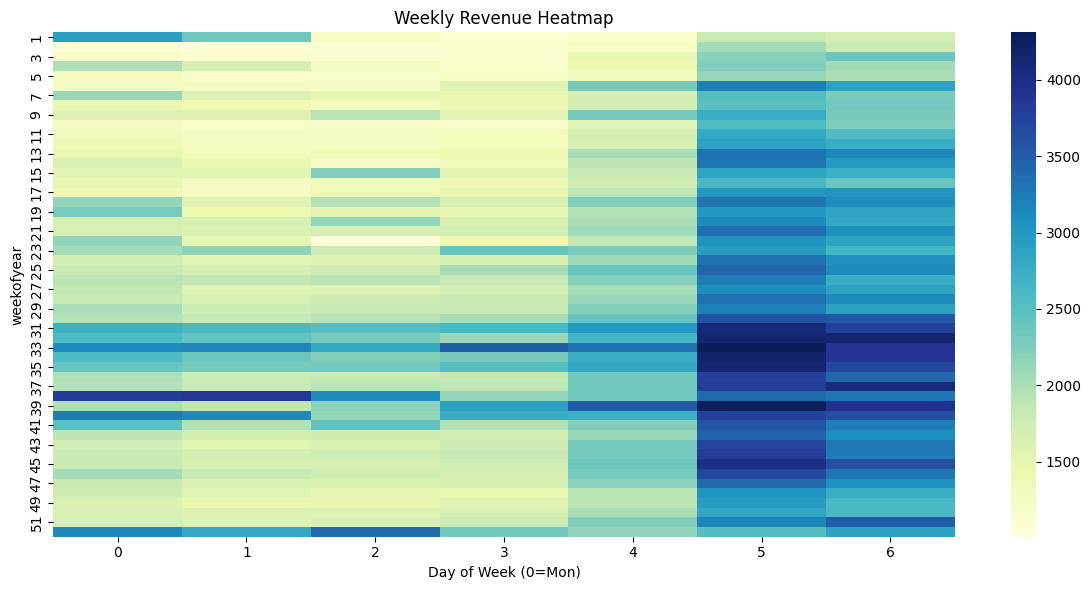

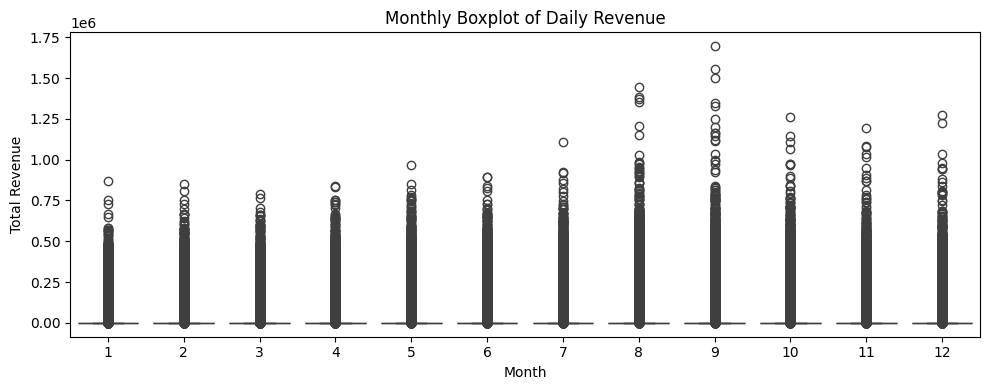

In [4]:
# STEP-2: 캘린더·결측 보완 & EDA -------------------------------------------
import os
import numpy as np
import pandas as pd
import seaborn as sns         # pip install seaborn
import matplotlib.pyplot as plt

# 0) (이전 단계에서 계산된) start_date, end_date, daily_summary, events 불러오기

# 1) 휴일 데이터 로드 & 캘린더 생성 -----------------------------------------
df_hol = pd.read_feather('data/2023~2025년_휴일_데이터_38rows.feather')
df_hol.rename(columns={'일자':'date','휴일명':'holiday_name'}, inplace=True)
df_hol['date'] = pd.to_datetime(df_hol['date'])

cal = pd.DataFrame({'date': pd.date_range(start_date, end_date, freq='D')})
cal['dow']        = cal['date'].dt.weekday                # 0=Mon
cal['is_holiday'] = cal['date'].isin(df_hol['date'])
cal['is_weekend'] = cal['dow'].isin([5, 6])
cal['is_offday']  = cal['is_weekend'] | cal['is_holiday']

# 연속 휴일(run) 계산
cal['block_id']  = (cal['is_offday'] != cal['is_offday'].shift(1)).cumsum()
cal['offday_run'] = cal.groupby('block_id')['is_offday'].transform('sum')
cal['offday_run'] = cal['offday_run'].where(cal['is_offday'], 0)
cal.drop(columns=['block_id'], inplace=True)


# 2) 마스터 그리드 (spot × vehicle_type × date) ----------------------------
spot_types = daily_summary[['spot_id','vehicle_type']].drop_duplicates()
full_grid = (
    pd.MultiIndex.from_product(
        [cal['date'],
         spot_types['spot_id'].unique(),
         spot_types['vehicle_type'].unique()],
        names=['date', 'spot_id', 'vehicle_type']
    )
    .to_frame(index=False)
    .merge(cal, on='date', how='left')
)

# 3) inventory_est 계산 (이전 이벤트 방식 그대로) ----------------------------
full_grid = full_grid.merge(
    events, on=['date','spot_id','vehicle_type'], how='left'
)
full_grid['change'] = full_grid['change'].fillna(0).astype(int)
full_grid['inventory_est'] = (
    full_grid
      .groupby(['spot_id','vehicle_type'])['change']
      .cumsum()
      .clip(lower=0)
)
full_grid.drop(columns='change', inplace=True)

# 4) 실측 매출과 병합 & 결측 처리 ------------------------------------------
full_daily = (
    full_grid
      .merge(daily_summary,
             on=['date','spot_id','vehicle_type'],
             how='left', validate='many_to_one')
)

for col in ['total_rev','vehicle_count','coupon_count']:
    full_daily[f'{col}_na'] = full_daily[col].isna()
full_daily[['total_rev','vehicle_count','coupon_count']] = (
    full_daily[['total_rev','vehicle_count','coupon_count']].fillna(0)
)
full_daily['total_rev_log1p'] = np.log1p(full_daily['total_rev'])

# 5) 간단 EDA ---------------------------------------------------------------
print("▶  데이터 모양:", full_daily.shape)
print("▶  누적 매출합   :", full_daily['total_rev'].sum())
print("▶  결측치 비율(spot·day):",
      full_daily['total_rev_na'].mean().round(4))

# (a) 요일별 평균 매출 히트맵 (Week-of-Year × DOW)
full_daily['weekofyear'] = full_daily['date'].dt.isocalendar().week
heatmap_df = (
    full_daily.groupby(['weekofyear','dow'])['total_rev']
              .mean()
              .unstack(fill_value=0)
)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, cmap='YlGnBu')
plt.title('Weekly Revenue Heatmap')
plt.xlabel('Day of Week (0=Mon)')
plt.tight_layout()
plt.show()

# (b) 월별 Boxplot ― 시즌성 확인
plt.figure(figsize=(10, 4))
sns.boxplot(x=full_daily['date'].dt.month, y=full_daily['total_rev'])
plt.title('Monthly Boxplot of Daily Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

# 6) 저장 (모델링용 피처-스토어) --------------------------------------------
os.makedirs('data/feature_store', exist_ok=True)
full_daily.to_feather('data/feature_store/daily_master.feather')
#full_daily.to_csv('data/feature_store/daily_master.csv')

In [8]:
full_daily[full_daily['inventory_est']>-1].head(20)

,date,spot_id,vehicle_type,dow,is_holiday,is_weekend,is_offday,offday_run,inventory_est,total_rev,vehicle_count,coupon_count,revenue_per_vehicle,total_rev_na,vehicle_count_na,coupon_count_na,total_rev_log1p,weekofyear
0,2023-01-06,1.0,경형,4,False,False,False,0,1,25440.0,1.0,1.0,25440.0,False,False,False,10.144117,1
1,2023-01-06,1.0,소형SUV,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1
2,2023-01-06,1.0,준중형,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1
3,2023-01-06,1.0,중형,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1
4,2023-01-06,1.0,준중형SUV,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1
5,2023-01-06,1.0,중형SUV,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1
6,2023-01-06,1.0,중형_HEV,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1
7,2023-01-06,1.0,소형SUV_HEV,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1
8,2023-01-06,1.0,준대형,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1
9,2023-01-06,1.0,준중형_HEV,4,False,False,False,0,0,0.0,0.0,0.0,NaN,True,True,True,0.000000,1


In [9]:
len(full_daily)

25712016

In [6]:
len(full_daily['date'].unique())

726

In [7]:
len(full_daily['vehicle_type'].unique())

19

In [8]:
len(full_daily['spot_id'].unique())

1864

In [12]:
df_vehicle = pd.read_csv('data/vehicle_info.csv')

In [13]:
df_vehicle['차량유형'].unique()

array(['준대형', '준중형', '중형SUV', '중형', '소형SUV', '경형', '소형', '전기', '수입차',
       '수입', '준중형SUV', '대형SUV', '소형SUV_HEV', '대형', '승합', '경차', '수입차_1',
       '중형_HEV', '준중형_HEV', '준대형_HEV', '경형SUV', '준중형SUV_HEV', '중형SUV_HEV',
       'SUV, RV', '소형트럭'], dtype=object)

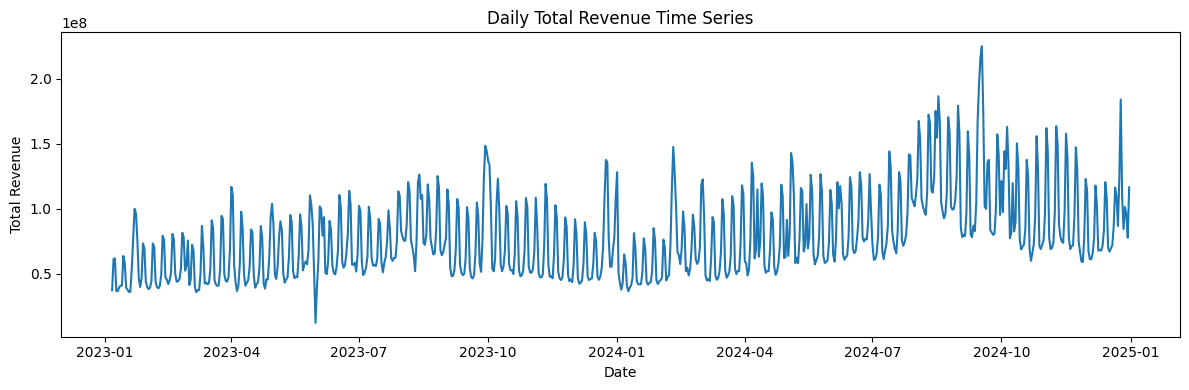

C:\Users\User\AppData\Local\Temp\ipykernel_5784\2365943196.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_inv['dow'] = df_pos_inv['date'].dt.dayofweek


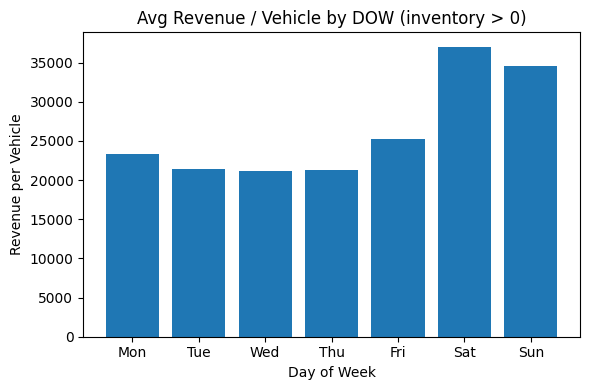

C:\Users\User\AppData\Local\Temp\ipykernel_5784\2365943196.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_inv['month'] = df_pos_inv['date'].dt.month


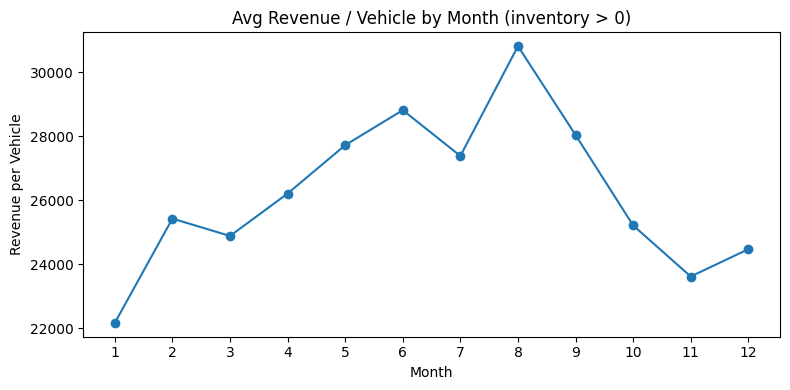

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# 1) 전체(스팟 합산) 일별 총매출 타임라인은 그대로
daily_sum = full_daily.groupby('date')['total_rev'].sum().sort_index()
plt.figure(figsize=(12, 4))
plt.plot(daily_sum.index, daily_sum.values)
plt.title('Daily Total Revenue Time Series')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

# ── 0) revenue_per_vehicle 계산 -----------------------------------------
#     vehicle_count==0 이면 분모가 0 ⇒ NaN, 재고==0 과 동일 처리
full_daily['revenue_per_vehicle'] = np.where(
    full_daily['inventory_est'] == 0,
    np.nan,                                               # 조건 1
    full_daily['total_rev'] / full_daily['vehicle_count'].replace(0, np.nan)
)

# 이후 여전히 NaN 인 값은
#  - inventory>0 & vehicle_count>0 인데 매출이 NaN ⇒ fill 0 으로
mask_fill_zero = (
    (full_daily['inventory_est'] > 0) &
    (full_daily['revenue_per_vehicle'].isna())
)
full_daily.loc[mask_fill_zero, 'revenue_per_vehicle'] = 0

# ── 1) 분석 플롯 ----------------------------------------------------------
df_pos_inv = full_daily[full_daily['inventory_est'] > 0]

# (a) 요일별
df_pos_inv['dow'] = df_pos_inv['date'].dt.dayofweek
dow_mean = df_pos_inv.groupby('dow')['revenue_per_vehicle'].mean()

plt.figure(figsize=(6, 4))
plt.bar(dow_mean.index, dow_mean.values)
plt.xticks(dow_mean.index, ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Avg Revenue / Vehicle by DOW (inventory > 0)')
plt.xlabel('Day of Week')
plt.ylabel('Revenue per Vehicle')
plt.tight_layout()
plt.show()

# (b) 월별
df_pos_inv['month'] = df_pos_inv['date'].dt.month
month_mean = df_pos_inv.groupby('month')['revenue_per_vehicle'].mean()

plt.figure(figsize=(8, 4))
plt.plot(month_mean.index, month_mean.values, marker='o')
plt.title('Avg Revenue / Vehicle by Month (inventory > 0)')
plt.xlabel('Month')
plt.ylabel('Revenue per Vehicle')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

In [6]:
full_daily[full_daily['inventory_est']>0]

,date,spot_id,vehicle_type,dow,is_holiday,is_weekend,is_offday,offday_run,inventory_est,total_rev,vehicle_count,coupon_count,revenue_per_vehicle,total_rev_na,vehicle_count_na,coupon_count_na,total_rev_log1p,weekofyear
0,2023-01-06,1.0,경형,4,False,False,False,0,1,25440.0,1.0,1.0,25440.00,False,False,False,10.144117,1
20,2023-01-06,2.0,소형SUV,4,False,False,False,0,1,5840.0,1.0,1.0,5840.00,False,False,False,8.672657,1
38,2023-01-06,7.0,경형,4,False,False,False,0,2,36579.5,2.0,3.0,18289.75,False,False,False,10.507271,1
57,2023-01-06,9.0,경형,4,False,False,False,0,1,41662.0,1.0,1.0,41662.00,False,False,False,10.637369,1
59,2023-01-06,9.0,준중형,4,False,False,False,0,1,3280.0,1.0,0.0,3280.00,False,False,False,8.095904,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25711946,2024-12-31,4362.0,중형_HEV,1,False,False,False,0,1,0.0,0.0,0.0,0.00,True,True,True,0.000000,1
25711963,2024-12-31,4390.0,준중형SUV,1,False,False,False,0,1,0.0,0.0,0.0,0.00,True,True,True,0.000000,1
25711980,2024-12-31,4331.0,준중형,1,False,False,False,0,2,56720.0,2.0,0.0,28360.00,False,False,False,10.945900,1
25711992,2024-12-31,4331.0,전기,1,False,False,False,0,1,76510.0,1.0,1.0,76510.00,False,False,False,11.245190,1


In [7]:
# 1) 매핑 사전 정의
mapping = {
    '준대형':            'Upper Midsize',
    '준중형':            'Compact',
    '중형SUV':          'Midsize SUV',
    '중형':             'Midsize',
    '소형SUV':          'Subcompact SUV',
    '경형':             'Microcar',
    '소형':             'Subcompact',
    '전기':             'Electric',
    '수입차':            'Imported',
    '수입':             'Imported',
    '준중형SUV':        'Compact SUV',
    '대형SUV':          'Fullsize SUV',
    '소형SUV_HEV':      'Subcompact SUV HEV',
    '대형':             'Fullsize',
    '승합':             'Passenger Van',
    '경차':             'Microcar',
    '수입차_1':         'Imported',
    '중형_HEV':         'Midsize HEV',
    '준중형_HEV':       'Compact HEV',
    '준대형_HEV':       'Upper Midsize HEV',
    '경형SUV':          'Micro SUV',
    '준중형SUV_HEV':    'Compact SUV HEV',
    '중형SUV_HEV':      'Midsize SUV HEV',
    'SUV, RV':          'SUV/RV',
    '소형트럭':         'Small Truck'
}


# ── 만약 기존 컬럼 덮어쓰고 싶다면:


In [8]:
import pandas as pd
import numpy as np
from datetime import timedelta
import weatherScore

# ─── 0) base df: full_daily (spot_id, vehicle_type, date …)
df = full_daily.copy()

# ─── 1) CALENDAR FEATURES ───────────────────────────────────────────────
df['dow']        = df['date'].dt.dayofweek           # 0 Mon
df['week']       = df['date'].dt.isocalendar().week
df['month']      = df['date'].dt.month
df['quarter']    = df['date'].dt.quarter
df['is_weekend'] = df['dow'].isin([5,6]).astype(int)

# holiday flags already in calendar; merge if absent
# df = df.merge(calendar[['date','is_holiday']], on='date', how='left')

# Long-holiday run length (공휴일+주말 연속길이)
df['offday_run'] = (
    df.groupby((~df['is_weekend'] & ~df['is_holiday']).cumsum())
      .cumcount() + 1
)
df['offday_run'] = df['offday_run'].where(df['is_weekend'] | df['is_holiday'], 0)

# ─── 2) LAG & ROLLING BY (spot_id, vehicle_type) ────────────────────────
lag_cols = []
for l in [1,7,28]:
    col = f'lag_{l}'
    df[col] = df.groupby(['spot_id','vehicle_type'])['total_rev'].shift(l)
    lag_cols.append(col)

df['roll_mean_7'] = (
    df.groupby(['spot_id','vehicle_type'])['total_rev']
      .shift(1).rolling(window=7, min_periods=1).mean()
)
df['roll_std_7'] = (
    df.groupby(['spot_id','vehicle_type'])['total_rev']
      .shift(1).rolling(window=7, min_periods=1).std()
)

# ─── 3) INVENTORY & UTILISATION ─────────────────────────────────────────
df['has_inventory'] = (df['inventory_est'] > 0).astype(int)

# recent utilisation = last-7-day rentals / inventory
df['rent_flag'] = (df['total_rev'] > 0).astype(int)
df['rent_count_7'] = (
    df.groupby(['spot_id','vehicle_type'])['rent_flag']
      .shift(1).rolling(7, min_periods=1).sum()
)
df['utilization_7'] = (
    df['rent_count_7'] / df['inventory_est'].replace(0, np.nan)
)

# ─── 4) COUPON / PROMOTION LAGS ─────────────────────────────────────────
df['coupon_flag_prev1'] = df.groupby(['spot_id','vehicle_type'])['coupon_count'].shift(1).gt(0).astype(int)
df['coupon_count_lag7'] = df.groupby(['spot_id','vehicle_type'])['coupon_count'].shift(7)



# 1) LOAD & PREPARE SPOT METADATA
df_spot = pd.read_csv('data/spot_info.csv')
df_spot.rename(columns={
    '스팟ID':       'spot_id',
    '지역(시/도)': 'region',
    '지역(구/군)': 'district'
}, inplace=True)
df_spot.dropna(subset=['spot_id'], inplace=True)
# keep all spots here—no filtering by insufficient

# Map your region names to region_code (define region_to_code dict elsewhere)
df_spot['region_code'] = df_spot['region'].map(region_to_code)

df = df.merge(
    df_spot[['spot_id','region_code']],
    on='spot_id',
    how='left'
)

# ─── B) MERGE WEATHER BY (region_code, date) ──────────────────────────────
weather_dfs = []
for code in df['region_code'].dropna().unique():
    w = pd.read_feather(
        f"data/weather/weather_{int(code)}.feather",
        columns=['date','T','RH','P','W','S']
    )
    w['date']        = pd.to_datetime(w['date'])
    w['region_code'] = code
    weather_dfs.append(w)

big_weather = pd.concat(weather_dfs, ignore_index=True)


# ─── 5) WEATHER ─────────────────────────────────────────────────────────
# assume you already built daily weather table `df_weather`
# df_weather columns: ['date','temp_avg','rain_mm','snow_cm','wind_ms','weather_score']
df = df.merge(
    big_weather,
    on=['region_code','date'],
    how='left'
)

calc = weatherScore.calculate_weather_score
scores = [
    calc(t, rh, p, w, s) 
    for t, rh, p, w, s 
    in zip(df['T'],
           df['RH'],
           df['P'],
           df['W'],
           df['S'])
]
df['weather_score'] = scores

df['rain_mm_lag1'] = df.groupby('region_code')['P'].shift(1)
df['temp_lag1']    = df.groupby('region_code')['T'].shift(1)


# ── 1) big_pop 준비 (이미 만드신 대로) ─────────────────────────────────
pop_dfs = []
for fp in glob.glob('data/spot/*_data.feather'):
    sid = int(os.path.basename(fp).split('_')[0])
    dfp = pd.read_feather(fp)
    # 월코드 → 날짜(월의 첫 날)
    dfp['year_month'] = pd.to_datetime(dfp['date'].astype(str), format='%Y%m').dt.to_period('M')
    dfp['spot_id']    = sid
    pop_dfs.append(dfp)

big_pop = pd.concat(pop_dfs, ignore_index=True)
big_pop = big_pop.drop_duplicates(subset=['spot_id','year_month'])

# ── 2) df 에 year_month 컬럼 생성 ────────────────────────────────────────
#    (df: full_daily 또는 df_model 등 현재 쓰시는 DataFrame)
df['year_month'] = df['date'].dt.to_period('M')

# ── 3) 병합 ─────────────────────────────────────────────────────────────
df = df.merge(
    big_pop.drop(columns=['date']),   # 원본 날짜컬럼은 필요없으니 제거
    on=['spot_id','year_month'],
    how='left'
)

raw_ages = [
    'male0AgeNmprCnt','feml0AgeNmprCnt',
    'male10AgeNmprCnt','feml10AgeNmprCnt',
    'male20AgeNmprCnt','feml20AgeNmprCnt',
    'male30AgeNmprCnt','feml30AgeNmprCnt',
    'male40AgeNmprCnt','feml40AgeNmprCnt',
    'male50AgeNmprCnt','feml50AgeNmprCnt',
    'male60AgeNmprCnt','feml60AgeNmprCnt',
    'male70AgeNmprCnt','feml70AgeNmprCnt',
    'male80AgeNmprCnt','feml80AgeNmprCnt',
    'male90AgeNmprCnt','feml90AgeNmprCnt',
    'male100AgeNmprCnt','feml100AgeNmprCnt'
]

# compute broad bands
df['pop_child']  = df['male0AgeNmprCnt']+df['feml0AgeNmprCnt']
df['pop_teen']   = df['male10AgeNmprCnt']+df['feml10AgeNmprCnt']
df['pop_adult']  = df['male20AgeNmprCnt']+df['feml20AgeNmprCnt']+df['male30AgeNmprCnt']+df['feml30AgeNmprCnt']+df['male40AgeNmprCnt']+df['feml40AgeNmprCnt']+df['male50AgeNmprCnt']+df['feml50AgeNmprCnt']

df['pop_senior'] = df['male100AgeNmprCnt']+ df['feml100AgeNmprCnt'] +df['male90AgeNmprCnt']+ df['feml90AgeNmprCnt'] +df['male80AgeNmprCnt']+df['feml80AgeNmprCnt']+df['male70AgeNmprCnt']+df['feml70AgeNmprCnt']+df['male60AgeNmprCnt']+df['feml60AgeNmprCnt']

# convert to proportions of total population
df['pct_child']  = df['pop_child']  / df['totNmprCnt']
df['pct_teen']   = df['pop_teen']   / df['totNmprCnt']
df['pct_adult']  = df['pop_adult']  / df['totNmprCnt']
df['pct_senior'] = df['pop_senior'] / df['totNmprCnt']


df['land_price_log'] = np.log1p(df['adj_land_price'])

drop_cols = raw_ages + [
    'year_month',
    'pop_child','pop_teen','pop_adult','pop_senior',

]
df.drop(columns=drop_cols, inplace=True)


# ─── 6) TARGET TRANSFORMS ───────────────────────────────────────────────
df['total_rev_log1p'] = np.log1p(df['total_rev'])
df['rev_per_vehicle'] = df['total_rev'] / df['inventory_est'].replace(0, np.nan)
df['rev_per_vehicle_log1p'] = np.log1p(df['rev_per_vehicle'].fillna(0))


import numpy as np

# day-of-year → [1..365] 사이를 0~2π 로 매핑
df['doy'] = df['date'].dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['doy'] / 365.0)
df['doy_cos'] = np.cos(2 * np.pi * df['doy'] / 365.0)

# month → [1..12] 사이를 0~2π 로 매핑
df['month'] = df['date'].dt.month
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12.0)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12.0)

# 이 두 쌍(doy_sin, doy_cos), (month_sin, month_cos)을 feature_cols 에 추가

# 1) 그룹별 평균 target (여기서는 log 매출) 계산
mean_rev = (
    df.groupby(['region_code','vehicle_type'])['total_rev_log1p']
      .mean()
      .reset_index()
      .rename(columns={'total_rev_log1p':'region_vehicle_mean_rev'})
)

# 2) 원본 df에 병합
df = df.merge(mean_rev, on=['region_code','vehicle_type'], how='left')

# 1) Total revenue per region per day
df['region_total_rev'] = (
    df
      .groupby(['date','region_code'])['total_rev']
      .transform('sum')
)

# 2) Total vehicle count per region per day
df['region_vehicle_count'] = (
    df
      .groupby(['date','region_code'])['vehicle_count']
      .transform('sum')
)

# 3) Revenue per vehicle at region level
df['region_rev_per_vehicle'] = (
    df['region_total_rev']
      / df['region_vehicle_count'].replace(0, np.nan)
)

df['vehicle_type'] = df['vehicle_type'].map(mapping).fillna(df['vehicle_type'])


# ─── 7) CLEAN-UP & SAVE ────────────────────────────────────────────────
feature_cols = [
    # ── Calendar
    'dow', 'week', 'month', 'quarter',
    'is_weekend', 'is_holiday', 'offday_run',

    # ── Lag & Rolling
    'lag_1', 'lag_7', 'lag_28',
    'roll_mean_7', 'roll_std_7',

    # ── Inventory & Utilization
    'inventory_est', 'has_inventory', 'utilization_7',

    # ── Vehicle & Coupon
    'vehicle_count', 'coupon_count',
    'coupon_flag_prev1', 'coupon_count_lag7',

    # ── Weather
    'T', 'RH', 'P', 'W', 'S',
    'weather_score', 'rain_mm_lag1', 'temp_lag1',

    # ── Demographics & Land Price
    'pct_child', 'pct_teen', 'pct_adult', 'pct_senior',
    'land_price_log',

    # ── Region‐Level Aggregates
    'region_total_rev', 'region_vehicle_count', 'region_rev_per_vehicle',

    # ── Static Categorical Keys
    'region_code'
]
feature_cols += ['doy_sin','doy_cos','month_sin','month_cos']
feature_cols += ['region_vehicle_mean_rev']

target_col = 'total_rev_log1p'

df_model = df_model = df[['date','spot_id','vehicle_type',target_col] + feature_cols].copy()

# 2) 결측 처리 예시
#    – 매출·대수·쿠폰 없던 날 → 0
for col in ['total_rev_log1p','vehicle_count','coupon_count']:
    df_model[col] = df_model[col].fillna(0)

#    – lag 초반 → 0
for lag in ['lag_1','lag_7','lag_28','roll_mean_7','roll_std_7','rain_mm_lag1',"coupon_flag_prev1","coupon_count_lag7",'utilization_7']:
    df_model[lag] = df_model[lag].fillna(0)

#    – weather 등 → forward/backward fill
for col in ['T','RH','P','W','S','weather_score']:
    df_model[col] = df_model[col].fillna(method='ffill').fillna(method='bfill')

#    – 기타 파생 피처도 모두 fillna(0) 또는 적절한 값으로 채우고,
#      마지막으로 target_col이 NaN인(모델링 불가) 행만 필터링
df_model = df_model[df_model[target_col].notna()]


df_model.to_feather('data/feature_store/daily_features.feather')
print('Saved feature matrix → daily_features.feather')


MemoryError: Unable to allocate 4.21 GiB for an array with shape (22, 25712016) and data type float64

In [1]:
from pathlib import Path
import pandas as pd
feat_path = Path("data/feature_store/daily_features.feather")
df_model = pd.read_feather(feat_path)

# 2) 결측 처리 예시
#    – 매출·대수·쿠폰 없던 날 → 0
for col in ['total_rev_log1p','vehicle_count','coupon_count',"region_total_rev","region_vehicle_count","region_rev_per_vehicle","region_vehicle_mean_rev"]:
    df_model[col] = df_model[col].fillna(0)

#    – lag 초반 → 0
for lag in ['lag_1','lag_7','lag_28','roll_mean_7','roll_std_7','rain_mm_lag1',"coupon_flag_prev1","coupon_count_lag7",'utilization_7']:
    df_model[lag] = df_model[lag].fillna(0)

#    – weather 등 → forward/backward fill
for col in ['T','RH','P','W','S','weather_score']:
    df_model[col] = df_model[col].fillna(method='ffill').fillna(method='bfill')

target_col = 'total_rev_log1p'
#    – 기타 파생 피처도 모두 fillna(0) 또는 적절한 값으로 채우고,
#      마지막으로 target_col이 NaN인(모델링 불가) 행만 필터링
df_model = df_model[df_model[target_col].notna()]


df_model.to_feather('data/feature_store/daily_features.feather')
print('Saved feature matrix → daily_features.feather')

C:\Users\User\AppData\Local\Temp\ipykernel_1512\543184561.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model[col] = df_model[col].fillna(method='ffill').fillna(method='bfill')


Saved feature matrix → daily_features.feather


In [3]:
del(df_model)

In [2]:
len(df_model)

25712016

In [59]:
# 1) 사용할 컬럼 리스트
cols = ['date','spot_id','vehicle_type', target_col] + feature_cols

# 2) 누락값 개수·비율 계산
missing_counts   = df[cols].isna().sum()
missing_percent  = (missing_counts / len(df) * 100).round(2)

print("▶ Missing counts per column:\n", missing_counts)
print("\n▶ Missing percentage per column:\n", missing_percent)

# 3) 누락이 있는 행 샘플 보기 (최초 5개)
mask_any_na = df[cols].isna().any(axis=1)
print("\n▶ First 5 rows with any NaN:\n", df.loc[mask_any_na, cols].head())

▶ Missing counts per column:
 date                       0
spot_id                    0
vehicle_type               0
total_rev_log1p            0
dow                        0
week                       0
month                      0
quarter                    0
is_weekend                 0
is_holiday                 0
offday_run                 0
lag_1                      0
lag_7                      0
lag_28                     0
roll_mean_7                0
roll_std_7                 0
inventory_est              0
has_inventory              0
utilization_7              0
vehicle_count              0
coupon_count               0
coupon_flag_prev1          0
coupon_count_lag7          0
T                          0
RH                         0
P                          0
W                          0
S                          0
weather_score              0
rain_mm_lag1               0
temp_lag1                  0
pct_child                  0
pct_teen                   0
pct_adult    

In [17]:
df_model.head(5)

,date,spot_id,vehicle_type,total_rev_log1p,dow,week,month,quarter,is_weekend,is_holiday,...,land_price_log,region_total_rev,region_vehicle_count,region_rev_per_vehicle,region_code,doy_sin,doy_cos,month_sin,month_cos,region_vehicle_mean_rev
991648,2023-02-03,1.0,Microcar,10.491024,4,5,2,1,0,False,...,13.125183,4.261627e+06,111.0,38393.034535,133,0.552435,0.833556,0.5,0.866025,1.629303
991668,2023-02-03,2.0,Subcompact SUV,10.860939,4,5,2,1,0,False,...,15.147650,4.261627e+06,111.0,38393.034535,133,0.552435,0.833556,0.5,0.866025,1.107719
991686,2023-02-03,7.0,Microcar,10.067348,4,5,2,1,0,False,...,14.799018,4.261627e+06,111.0,38393.034535,133,0.552435,0.833556,0.5,0.866025,1.629303
991705,2023-02-03,9.0,Microcar,0.000000,4,5,2,1,0,False,...,12.689327,4.261627e+06,111.0,38393.034535,133,0.552435,0.833556,0.5,0.866025,1.629303
991707,2023-02-03,9.0,Compact,0.000000,4,5,2,1,0,False,...,12.689327,4.261627e+06,111.0,38393.034535,133,0.552435,0.833556,0.5,0.866025,2.182772


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm  # tqdm for progress bars

# ── 0) Load dataset ───────────────────────────────────────────────────────
df = pd.read_feather('data/feature_store/daily_features.feather')
target = 'total_rev_log1p'

# ── 1) Define feature blocks ─────────────────────────────────────────────
feature_blocks = {
    'calendar':    ['dow','week','month','quarter','is_weekend','is_holiday','offday_run'],
    'lags':        ['lag_1','lag_7','lag_28','roll_mean_7','roll_std_7'],
    'inventory':   ['inventory_est','has_inventory','utilization_7'],
    'coupon':      ['vehicle_count','coupon_count','coupon_flag_prev1','coupon_count_lag7'],
    'weather':     ['rain_mm_lag1','RH','W'],
    #'demo_land':   ['pct_teen'],
    'region_agg':  ['region_total_rev','region_vehicle_count','region_rev_per_vehicle'],
    #'cyclic':      ['month_cos'],
    'interaction': ['region_vehicle_mean_rev']
}

# ── 2) A/B test: sequentially add blocks ─────────────────────────────────
results = []
baseline_feats = []

tscv = TimeSeriesSplit(n_splits=3)

for block_name, block_feats in tqdm(feature_blocks.items(), desc="Feature Blocks"):
    feats = baseline_feats + block_feats
    wapes = []
    
    # inner loop with tqdm
    for train_idx, val_idx in tqdm(tscv.split(df), total=tscv.get_n_splits(),
                                   desc=f"  CV for {block_name}", leave=False):
        train, val = df.iloc[train_idx], df.iloc[val_idx]
        lgb_train = lgb.Dataset(train[feats], label=train[target])
        lgb_val   = lgb.Dataset(val[feats],   label=val[target], reference=lgb_train)
        
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'learning_rate': 0.05,
            'num_leaves': 63,
            'verbose': -1
        }
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=500,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=0)        # suppress built-in logging
            ]
            
        )
        
        pred = np.expm1(model.predict(val[feats], num_iteration=model.best_iteration))
        actual = np.expm1(val[target])
        wape = np.abs(actual - pred).sum() / np.maximum(np.abs(actual).sum(), 1e-3)
        wapes.append(wape)
    
    avg_wape = np.mean(wapes)
    results.append({'block': block_name, 'features': len(block_feats), 'wape': avg_wape})
    baseline_feats += block_feats

# ── 3) Show results ───────────────────────────────────────────────────────
results_df = pd.DataFrame(results)
results_df



Feature Blocks:   0%|          | 0/9 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[53]	valid_0's l1: 5.10075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid_0's l1: 5.18519


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 5.1324


Feature Blocks:  11%|█         | 1/9 [00:12<01:38, 12.30s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 2.98223


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[367]	valid_0's l1: 2.88247


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[365]	valid_0's l1: 2.74825


Feature Blocks:  22%|██▏       | 2/9 [00:26<01:31, 13.13s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 2.99452


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's l1: 2.90376


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[429]	valid_0's l1: 2.74648


Feature Blocks:  33%|███▎      | 3/9 [00:39<01:20, 13.34s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's l1: 0.205159


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's l1: 0.188792


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's l1: 0.195118


Feature Blocks:  44%|████▍     | 4/9 [00:51<01:04, 12.95s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's l1: 0.204889


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's l1: 0.188879


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's l1: 0.19518


Feature Blocks:  56%|█████▌    | 5/9 [01:05<00:52, 13.19s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's l1: 0.205009


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's l1: 0.188777


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's l1: 0.194978


Feature Blocks:  67%|██████▋   | 6/9 [01:18<00:39, 13.21s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[178]	valid_0's l1: 0.19813


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's l1: 0.185122


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's l1: 0.190816


Feature Blocks:  78%|███████▊  | 7/9 [01:33<00:27, 13.62s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's l1: 0.198191


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[194]	valid_0's l1: 0.185119


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's l1: 0.1908


Feature Blocks:  89%|████████▉ | 8/9 [01:47<00:13, 13.86s/it]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[178]	valid_0's l1: 0.19613


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's l1: 0.183445


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	valid_0's l1: 0.189717


Feature Blocks: 100%|██████████| 9/9 [02:02<00:00, 13.64s/it]


,block,features,wape
0,calendar,7,0.992391
1,lags,5,0.743138
2,inventory,3,0.737783
3,coupon,4,0.345268
4,weather,3,0.345266
5,demo_land,1,0.345287
6,region_agg,3,0.333713
7,cyclic,1,0.333765
8,interaction,1,0.330406


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm

# 0) 데이터 불러오기
df = pd.read_feather('data/feature_store/daily_features.feather')
target = 'total_rev_log1p'

# 1) 베이스라인 피처 (weather, cyclic, demo_land 제외)
baseline_features = [
    'dow','week','month','quarter','is_weekend','is_holiday','offday_run',
    'lag_1','lag_7','lag_28','roll_mean_7','roll_std_7',
    'inventory_est','has_inventory','utilization_7',
    'coupon_flag_prev1','coupon_count_lag7',
    'region_total_rev','region_vehicle_count','region_rev_per_vehicle',
    'region_vehicle_mean_rev'
]

# 2) 테스트할 개별 피처 리스트
blocks = {
    'weather': ['T','RH','P','W','S','weather_score','rain_mm_lag1','temp_lag1'],
    'cyclic':  ['doy_sin','doy_cos','month_sin','month_cos'],
    'demo_land': ['pct_child','pct_teen','pct_adult','pct_senior','land_price_log']
}

results = []

tscv = TimeSeriesSplit(n_splits=3)
params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 63,
    'verbose': -1
}

# 3) 블록별, 피처별 루프
for block, feats in blocks.items():
    for feat in tqdm(feats, desc=f"Testing block {block}"):
        wapes = []
        features = baseline_features + [feat]
        
        for train_idx, val_idx in tscv.split(df):
            train, val = df.iloc[train_idx], df.iloc[val_idx]
            lgb_train = lgb.Dataset(train[features], label=train[target])
            lgb_val   = lgb.Dataset(val[features],   label=val[target], reference=lgb_train)
            model = lgb.train(
                params, lgb_train, num_boost_round=500,
                valid_sets=[lgb_val],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
            )
            
            pred   = np.expm1(model.predict(val[features], num_iteration=model.best_iteration))
            actual = np.expm1(val[target])
            wape   = np.abs(actual - pred).sum() / np.maximum(np.abs(actual).sum(), 1e-3)
            wapes.append(wape)
        
        results.append({
            'block': block,
            'feature': feat,
            'wape': np.mean(wapes)
        })

# 4) 결과 정리
res_df = pd.DataFrame(results).sort_values(['block','wape'])
print(res_df)


In [25]:
final_features = [
    # ── Calendar
    'dow','week','month','quarter','is_weekend','is_holiday','offday_run',
    # ── Lag & Rolling
    'lag_1','lag_7','lag_28','roll_mean_7','roll_std_7',
    # ── Inventory & Utilization
    'inventory_est','has_inventory','utilization_7',
    # ── Coupon / Promotion
    'coupon_flag_prev1','coupon_count_lag7',
    # ── Weather
    'rain_mm_lag1','RH','W',
    # ── Region-Level Aggregates
    'region_total_rev','region_vehicle_count','region_rev_per_vehicle',
    # ── Interaction (Region × Vehicle)
    'region_vehicle_mean_rev',
    # ── Final Touch: Interaction
]

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
import optuna, numpy as np

def objective(trial):
    params = dict(
        num_leaves        = trial.suggest_int("leaves", 31, 127),
        learning_rate     = trial.suggest_float("lr", 0.01, 0.2, log=True),
        min_data_in_leaf  = trial.suggest_int("min_leaf", 20, 300),
        feature_fraction  = trial.suggest_float("ff", 0.6, 1.0),
        lambda_l1         = trial.suggest_float("l1", 0, 5),
        lambda_l2         = trial.suggest_float("l2", 0, 5),
        n_estimators      = 2000,
        objective         = "regression",
        metric            = "mae",
        verbosity         = -1
    )
    model = LGBMRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=3)
    wapes = []
    
    for tr_idx, val_idx in tscv.split(df):
        X_tr, y_tr = df.iloc[tr_idx][final_features], df.iloc[tr_idx][target]
        X_val, y_val = df.iloc[val_idx][final_features], df.iloc[val_idx][target]
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=0)
            ]
        )
        
        # best_iteration_을 사용해 예측
        preds = model.predict(
            X_val,
            num_iteration=model.best_iteration_
        )
        # 로그 스케일 역변환 후 WAPE 계산
        actual = np.expm1(y_val)
        pred_actual = np.expm1(preds)
        wape = np.abs(actual - pred_actual).sum() / np.maximum(np.abs(actual).sum(), 1e-3)
        wapes.append(wape)
    return np.mean(wapes)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60)
best_params = study.best_params


In [29]:
print(best_params)

{'leaves': 121, 'lr': 0.010038493192949303, 'min_leaf': 175, 'ff': 0.6176763870690934, 'l1': 4.735069045295162, 'l2': 1.712495971979193}


In [30]:
test_days = 30
cutoff = df['date'].max() - pd.Timedelta(days=test_days)
train_df = df[df['date'] <= cutoff]
test_df  = df[df['date']  > cutoff]

In [31]:
from lightgbm import LGBMRegressor
import numpy as np

model = LGBMRegressor(**best_params)
model.fit(
    train_df[final_features], train_df[target],
    eval_set=[(test_df[final_features], test_df[target])],
    eval_metric='mae',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's l1: 2.96568	valid_0's l2: 16.159


LGBMRegressor(ff=0.6176763870690934, l1=4.735069045295162, l2=1.712495971979193,
              leaves=121, lr=0.010038493192949303, min_leaf=175)

In [32]:
preds_log = model.predict(test_df[final_features], num_iteration=model.best_iteration_)
y_true, y_pred = np.expm1(test_df[target]), np.expm1(preds_log)
wape_test = np.abs(y_true - y_pred).sum() / np.maximum(np.abs(y_true).sum(), 1e-3)
print(f"HOLD-OUT WAPE: {wape_test:.4f}")


HOLD-OUT WAPE: 0.7878


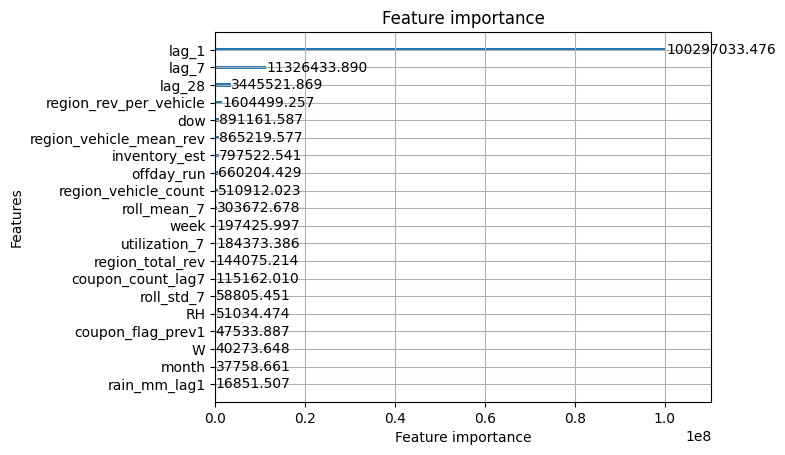

In [33]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.show()

In [35]:
# 예시 최종 categorical cols
cat_cols = [
    'spot_id','vehicle_type',
    'region_code',
    'dow','month','is_holiday'
]

In [46]:
final_features = [
    # ── Calendar
    'dow','week','month','quarter','is_weekend','is_holiday','offday_run',
    # ── Lag & Rolling
    'lag_1','lag_7','lag_28','roll_mean_7','roll_std_7',
    # ── Inventory & Utilization
    'inventory_est','has_inventory','utilization_7',
    # ── Coupon / Promotion
    'coupon_flag_prev1','coupon_count_lag7',
    # ── Weather
    'rain_mm_lag1','RH','W',
    # ── Region-Level Aggregates
    'region_total_rev','region_vehicle_count','region_rev_per_vehicle',
    # ── Interaction (Region × Vehicle)
    'region_vehicle_mean_rev',
    # ── Final Touch: Interaction
    'spot_id','vehicle_type',
    'region_code',
]

In [49]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool

# ── 0) assume `df` is your full daily_features DataFrame,
#      and you already have:
#      final_features = [ ... your feature list ... ]
#      target_col     = 'total_rev_log1p'
#      cat_cols       = [ ... your categorical list ... ]

# 1) Hold-out split: last 30 days as validation
cutoff = df['date'].max() - pd.Timedelta(days=30)
train_df = df[df['date'] <= cutoff].reset_index(drop=True)
val_df   = df[df['date']  > cutoff].reset_index(drop=True)

# 2) Build X / y
trainX = train_df[final_features]
trainY = train_df[target_col]
valX   = val_df[final_features]
valY   = val_df[target_col]

# Convert all cat features to string
for c in cat_cols:
    df[c] = df[c].astype(str)

# 3) Create CatBoost pools
train_pool = Pool(trainX, trainY, cat_features=cat_cols)
val_pool   = Pool(valX,   valY,   cat_features=cat_cols)

# 4) Fit your model
cat = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.05,
    depth=8,
    loss_function='MAE',
    eval_metric='MAE',
    early_stopping_rounds=150,
    verbose=False
)
cat.fit(train_pool, eval_set=val_pool)

# 5) Predict & compute hold-out WAPE
pred_log = cat.predict(valX)
y_true   = np.expm1(valY)
y_pred   = np.expm1(pred_log)
wape_holdout = np.abs(y_true - y_pred).sum() / np.maximum(np.abs(y_true).sum(),1e-3)
print(f"HOLD-OUT WAPE (CatBoost): {wape_holdout:.4f}")

HOLD-OUT WAPE (CatBoost): 0.6292


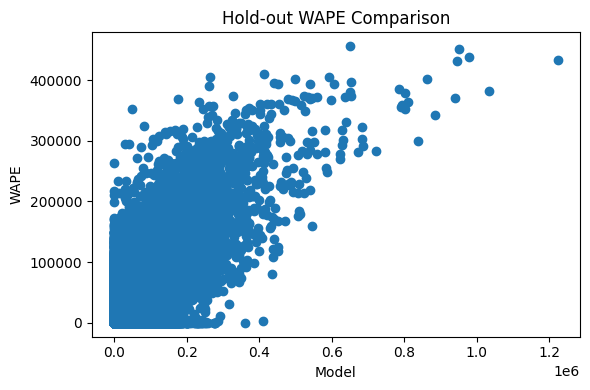

In [57]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 4))
plt.scatter(y_true, y_pred)
#plt.plot([0,1e6],[0,1e6])
plt.title('Hold-out WAPE Comparison')
plt.xlabel('Model')
plt.ylabel('WAPE')

plt.tight_layout()
plt.show()